![image](../data/images/banner.png)

In [ ]:
import os
from pathlib import Path
import random
import time
import shutil
import zipfile

import kaggle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from ultralytics import YOLO

random_state = random.randint(1,999)
display(random_state)

# COnfiguraciones para tensorflow
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-10-06 22:46:39.481100: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 22:46:39.539307: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 22:46:39.573233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 22:46:39.638536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 22:46:39.651743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 22:46:39.754208: I tensorflow/core/platform/cpu_feature_gu

931

In [ ]:
! cat /root/.config/Ultralytics/settings.json
! sed -i 's|"datasets_dir":.*|"datasets_dir": "/app",|' /root/.config/Ultralytics/settings.json
! cat /root/.config/Ultralytics/settings.json

{
  "settings_version": "0.0.6",
  "datasets_dir": "/app",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "e9f2075fc19916239a376a302c9631266f63b2fead1a3a29759f6048a7455a2e",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": true,
  "vscode_msg": true
}{
  "settings_version": "0.0.6",
  "datasets_dir": "/app",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "e9f2075fc19916239a376a302c9631266f63b2fead1a3a29759f6048a7455a2e",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": true,
  "vscode_msg": true
}

In [ ]:
# Download data from kaggle

RAW_DATA_ZIP = "data/raw/data2/rsud20k-bangladesh-road-scene-understanding.zip"
EXTRACTED_DATA = "data/preprocessed/data2"

dataset = "hasibzunair/rsud20k-bangladesh-road-scene-understanding"
kaggle.api.dataset_download_files(dataset, path='data/raw/data2')

with zipfile.ZipFile(RAW_DATA_ZIP, 'r') as zip_ref:
        zip_ref.extractall(EXTRACTED_DATA)
        print(f"Extracted all files to {EXTRACTED_DATA}")

DATA_DIR = Path("data/preprocessed/data2/rsud20k")
DATA_DIR

Dataset URL: https://www.kaggle.com/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding
Extracted all files to data/preprocessed/data2


PosixPath('data/preprocessed/data2/rsud20k')

In [ ]:
def generate_and_validate_paths(data_dir):
    subdirs = ['images', 'labels']
    categories = ['test', 'train', 'val']
    folder_dict = {}

    print("Printing folder paths and checking their validity:")
    for subdir in subdirs:
        for category in categories:
            folder_name = f"{subdir}_{category}"
            folder_path = data_dir / subdir / category
            folder_dict[folder_name] = folder_path
            print(f"{folder_name}: {folder_path}")
            print(f"Is the path valid?: {folder_path.exists()}")

    return folder_dict

folder_dict = generate_and_validate_paths(DATA_DIR)
folder_dict

Printing folder paths and checking their validity:
images_test: data/preprocessed/data2/rsud20k/images/test
Is the path valid?: True
images_train: data/preprocessed/data2/rsud20k/images/train
Is the path valid?: True
images_val: data/preprocessed/data2/rsud20k/images/val
Is the path valid?: True
labels_test: data/preprocessed/data2/rsud20k/labels/test
Is the path valid?: True
labels_train: data/preprocessed/data2/rsud20k/labels/train
Is the path valid?: True
labels_val: data/preprocessed/data2/rsud20k/labels/val
Is the path valid?: True


{'images_test': PosixPath('data/preprocessed/data2/rsud20k/images/test'),
 'images_train': PosixPath('data/preprocessed/data2/rsud20k/images/train'),
 'images_val': PosixPath('data/preprocessed/data2/rsud20k/images/val'),
 'labels_test': PosixPath('data/preprocessed/data2/rsud20k/labels/test'),
 'labels_train': PosixPath('data/preprocessed/data2/rsud20k/labels/train'),
 'labels_val': PosixPath('data/preprocessed/data2/rsud20k/labels/val')}

##Análisis exploratorio

En la medida que se busca construir un modelo capaz de detectar y clasificar automáticamente a los actores viales en imágenes, con el fin de obtener información crucial para entender las dinámicas del tráfico en Bangladesh, se ha llevado a cabo un preprocesamiento de datos orientado a la detección de objetos en estas imágenes. El objetivo del preprocesamiento es validar la coincidencia entre imágenes y etiquetas, y analizar el formato y tamaño de las imágenes. Además, se extraen las dimensiones (ancho y alto) de cada imagen para asegurar que sean consistentes.

Se puede evidenciar que todas las imágenes analizadas cumplen con el formato esperado para el modelo YOLO, donde los formatos aceptados incluyen .jpg, .jpeg, y .png. En cuanto a la distribución por conjuntos: el conjunto de entrenamiento (train) contiene 18,681 imágenes válidas, todas con un tamaño de 1920x1080 píxeles. El conjunto de validación (val) contiene 1,004 imágenes, mientras que el conjunto de prueba (test) incluye 649 imágenes, ambos con las mismas dimensiones de 1920x1080 píxeles.

La homogeneidad de los tamaños de las imágenes asegura que no habrá problemas relacionados con tamaños inconsistentes al entrenar el modelo. Además, se realizó una revisión de la distribución de clases en el conjunto de imágenes para entender su contenido y evaluar si existe un desbalance severo entre clases, lo cual podría afectar negativamente el rendimiento del modelo de detección de objetos.

El análisis de las etiquetas revela un desbalance significativo entre las clases, lo que podría influir en el rendimiento del modelo. La Clase 0 (persona) tiene una gran predominancia con 35,645 instancias, mientras que clases como la Clase 12 (human hauler) con 517 instancias y la Clase 11 (covered van) con 692 instancias están subrepresentadas. Este desbalance sugiere que el modelo podría volverse más preciso al detectar las clases mayoritarias (como personas y vehículos privados), pero menos efectivo al identificar las clases minoritarias (como los "human haulers").

In [ ]:
def generate_image_paths(data_dir):
    subdirs = ['images']
    data_dir = Path(data_dir)
    images_folder = data_dir / subdirs[0]
    categories = ['test', 'train', 'val']
    folder_paths = [images_folder / category for category in categories]
    train_folder = images_folder / 'train'
    train_images = list(train_folder.glob('*'))
    return folder_paths, train_images

def process_image_folders(folder_list, img_ext):
    img_name_list = []
    img_width_list = []
    img_height_list = []
    img_folder_list = []
    img_format_list = []

    for folder in folder_list:
        parent_name = folder.name
        for img_path in folder.iterdir():
            if img_path.is_file():
                img_folder_list.append(parent_name)
                img_name_list.append(img_path.name)

                img_format = img_path.suffix.lower()
                img_format_list.append(
                    "ok" if img_format in img_ext else "not ok")

                with Image.open(img_path) as img:
                    width, height = img.size
                    img_width_list.append(width)
                    img_height_list.append(height)

    data_model = {
        "folder": img_folder_list,
        "image_name": img_name_list,
        "width": img_width_list,
        "height": img_height_list,
        "format": img_format_list
    }

    return pd.DataFrame(data=data_model)

IMAGE_EXT = {'.jpg', '.jpeg', '.png'}
LABEL_EXT = {'.txt'}
folder_list, train_images = generate_image_paths(DATA_DIR)
report_df = process_image_folders(folder_list, IMAGE_EXT)

In [ ]:
report_df_group = report_df.groupby(
    ['folder', 'format', 'width', 'height']).count()
report_df_group

image_name
folder format width height            
test   ok     1920  1080           649
train  ok     1920  1080         18681
val    ok     1920  1080          1004

In [ ]:
# Shuffle train images
random.shuffle(train_images)
selected_images = train_images[:9]

print("Selected image paths after shuffle:")
for img in selected_images:
    print(img)

Selected image paths after shuffle:
data/preprocessed/data2/rsud20k/images/train/train18736.jpg
data/preprocessed/data2/rsud20k/images/train/train17431.jpg
data/preprocessed/data2/rsud20k/images/train/train18331.jpg
data/preprocessed/data2/rsud20k/images/train/train10189.jpg
data/preprocessed/data2/rsud20k/images/train/train11959.jpg
data/preprocessed/data2/rsud20k/images/train/train8028.jpg
data/preprocessed/data2/rsud20k/images/train/train17265.jpg
data/preprocessed/data2/rsud20k/images/train/train15000.jpg
data/preprocessed/data2/rsud20k/images/train/train17417.jpg


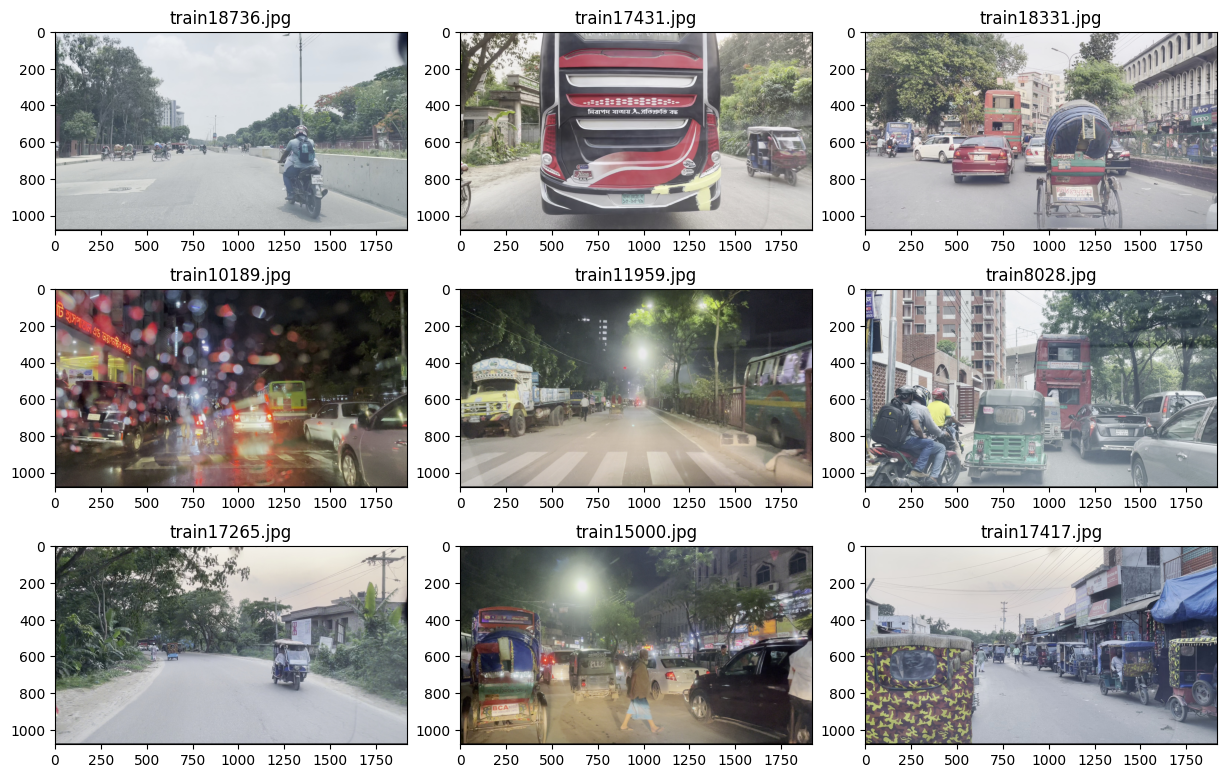

In [ ]:
def show_ima_matrix(image_list, show_axis=False):
    MAX_SIZE = 9
    if len(image_list) != MAX_SIZE:
        raise(f"Se requieren exactamente {MAX_SIZE} imágenes para crear la matriz.")

    plt.figure(figsize=(15, 10))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(wspace=0.15, hspace=0.005)
    for i in range(MAX_SIZE):
        ima_file = image_list[i]
        ima_name = os.path.basename(ima_file)
        ax = plt.subplot(gs1[i])
        plt.imshow(np.array(Image.open(ima_file)))
        plt.title(ima_name[:20])
        plt.axis("on" if show_axis else "off")
    plt.show()
show_ima_matrix(selected_images, show_axis=True)

In [ ]:
def verify_alignment(folder_dict):
    """
    Verifies alignment between images and corresponding label files.

    Args:
        folder_dict (dict): Dictionary containing image and label folder paths.

    Returns:
        None: Prints images without labels and labels without images for each folder.
    """
    categories = ['train', 'test', 'val']

    for category in categories:
        img_folder = folder_dict[f'images_{category}']
        lbl_folder = folder_dict[f'labels_{category}']

        img_files = {f.stem for f in img_folder.iterdir() if f.suffix.lower() in IMAGE_EXT}
        lbl_files = {f.stem for f in lbl_folder.iterdir() if f.suffix.lower() in LABEL_EXT}

        imgs_without_labels = img_files - lbl_files
        if imgs_without_labels:
            print(f"Imágenes sin etiquetas en la carpeta {img_folder}: {', '.join(imgs_without_labels)}")

        labels_without_imgs = lbl_files - img_files
        if labels_without_imgs:
            print(f"Etiquetas sin imágenes en la carpeta {lbl_folder}: {', '.join(labels_without_imgs)}")

verify_alignment(folder_dict)

##Procesamiento
Debido a las cosideraciones de recursos se selecciona un porcentaje del dataset para crear un subconjunto más pequeño. Este subconjunto se guarda en nuevas carpetas para las imágenes y etiquetas, dado que las imágenes deben ser redimensionadas y normalizadas según el modelo que vayas a usar.
Crea datasets en streaming a partir de generadores que cargan imágenes y etiquetas conforme son necesarias. Esto evita cargar todo el dataset en memoria, lo que es útil para datasets grandes.
Se decodificar la imagen, redimensionando el tamaño especificado (640, 640) píxeles, luego la imagen se normaliza dividiendo los valores de los píxeles por 255.0, convirtiendo los valores de los píxeles a un rango entre 0 y 1. Esto es importante para que los modelos de aprendizaje profundo puedan procesar eficientemente los datos.

Los datasets de entrenamiento, validación y prueba se estructuran en lotes (batch_size) y se optimizan con prefetch para mejorar el rendimiento durante el entrenamiento del modelo.
El código devuelve tres datasets: uno para entrenamiento, otro para validación y uno para prueba, listos para ser usados en un pipeline de entrenamiento de TensorFlow.

In [ ]:
def create_datasets(folder_dict, batch_size=4, image_size=(640, 640), sample_size=0.1):
    """
    Creates TensorFlow datasets for training, validation, and test with streaming data loading,
    and also samples a subset of the dataset into new folders.

    Args:
        folder_dict (dict): Dictionary containing folder paths for images and labels.
        batch_size (int): Size of the data batches for training, validation, and test.
        image_size (tuple): Size to which images will be resized (height, width).
        sample_size (float): Percentage of the dataset to sample and move to new folders.

    Returns:
        train_dataset (tf.data.Dataset): Streaming dataset for training.
        val_dataset (tf.data.Dataset): Streaming dataset for validation.
        test_dataset (tf.data.Dataset): Streaming dataset for test.
    """

    def create_image_and_label_paths(image_folder, label_folder):
        """
        Generates lists of image paths and corresponding label paths.

        Args:
            image_folder (Path): Folder containing images.
            label_folder (Path): Folder containing labels.

        Returns:
            image_paths (list): List of image paths.
            label_paths (list): List of corresponding label paths.
        """
        image_paths = sorted(list(image_folder.glob('*.jpg')))
        label_paths = [label_folder / img_path.with_suffix('.txt').name for img_path in image_paths]
        return image_paths, label_paths

    def load_image_and_label(image_path, label_path):
        """
        Loads an image and its corresponding label.

        Args:
            image_path (str): Path to the image.
            label_path (str): Path to the label.

        Returns:
            image (tensor): Resized and normalized image.
            label (tensor): Label as a tensor.
        """
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, image_size)
        image = image / 255.0

        label = tf.io.read_file(label_path)
        label = tf.strings.strip(label)
        label = tf.strings.split(label, '\n')

        label = tf.strings.split(label)
        label = tf.strings.to_number(label, out_type=tf.float32)

        return image, label

    def image_label_generator(image_paths, label_paths):
        """
        Generates image-label pairs in streaming mode.

        Args:
            image_paths (list): List of image paths.
            label_paths (list): List of corresponding label paths.

        Yields:
            image (tensor): Resized and normalized image.
            label (tensor): Label as a tensor.
        """
        for img_path, lbl_path in zip(image_paths, label_paths):
            yield str(img_path), str(lbl_path)  # Convert paths to strings

    def create_sampled_folders(sampled_image_paths, sampled_label_paths, sample_folder):
        """
        Creates new folders for sampled images and labels and moves files into them.

        Args:
            sampled_image_paths (list): List of sampled image paths.
            sampled_label_paths (list): List of corresponding sampled label paths.
            sample_folder (Path): Destination folder for the sampled data.
        """
        image_folder = sample_folder / "images"
        label_folder = sample_folder / "labels"
        os.makedirs(image_folder, exist_ok=True)
        os.makedirs(label_folder, exist_ok=True)

        for img_path, lbl_path in zip(sampled_image_paths, sampled_label_paths):
            # Load and transform the image
            image = tf.io.read_file(str(img_path))  # Ensure to convert to string
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, image_size)
            image = image / 255.0

            # Save the transformed image
            transformed_image_path = image_folder / img_path.name
            tf.io.write_file(str(transformed_image_path), tf.image.encode_jpeg(tf.cast(image * 255, tf.uint8)))

            # Copy the label file
            shutil.copy(str(lbl_path), label_folder / lbl_path.name)  # Ensure to convert to string

        print(f"Sampled images saved to: {image_folder}")
        print(f"Sampled labels saved to: {label_folder}")

    # Paths for train, validation, and test datasets
    train_image_paths, train_label_paths = create_image_and_label_paths(
        folder_dict['images_train'], folder_dict['labels_train']
    )

    val_image_paths, val_label_paths = create_image_and_label_paths(
        folder_dict['images_val'], folder_dict['labels_val']
    )

    test_image_paths, test_label_paths = create_image_and_label_paths(
        folder_dict['images_test'], folder_dict['labels_test']
    )

    # Sample: select a percentage of the training, validation, and test sets
    total_train_samples = len(train_image_paths)
    sample_size_count = int(total_train_samples * sample_size)

    sampled_train_image_paths = train_image_paths[:sample_size_count]
    sampled_train_label_paths = train_label_paths[:sample_size_count]

    # Create new sampled folders for train, val, and test
    sample_train_folder = Path("data/sample/train")
    sample_val_folder = Path("data/sample/val")
    sample_test_folder = Path("data/sample/test")

    create_sampled_folders(sampled_train_image_paths, sampled_train_label_paths, sample_train_folder)
    create_sampled_folders(val_image_paths, val_label_paths, sample_val_folder)
    create_sampled_folders(test_image_paths, test_label_paths, sample_test_folder)

    # Streaming datasets (for TensorFlow training)
    train_dataset = tf.data.Dataset.from_generator(
        lambda: image_label_generator(sampled_train_image_paths, sampled_train_label_paths),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    )
    train_dataset = train_dataset.map(
        lambda img, lbl: load_image_and_label(img, lbl), num_parallel_calls=tf.data.AUTOTUNE
    )
    train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_generator(
        lambda: image_label_generator(val_image_paths, val_label_paths),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    )
    val_dataset = val_dataset.map(
        lambda img, lbl: load_image_and_label(img, lbl), num_parallel_calls=tf.data.AUTOTUNE
    )
    val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_generator(
        lambda: image_label_generator(test_image_paths, test_label_paths),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    )
    test_dataset = test_dataset.map(
        lambda img, lbl: load_image_and_label(img, lbl), num_parallel_calls=tf.data.AUTOTUNE
    )
    test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = create_datasets(
    folder_dict,
    image_size=(640, 640),
    sample_size=0.2,
)

# Verify
for image, label in train_dataset.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())

Sampled images saved to: data/sample/train/images
Sampled labels saved to: data/sample/train/labels
Sampled images saved to: data/sample/val/images
Sampled labels saved to: data/sample/val/labels
Sampled images saved to: data/sample/test/images
Sampled labels saved to: data/sample/test/labels
Image shape: (4, 640, 640, 3)
Label: [array([[          1,     0.36719,     0.64074,    0.026042,    0.090741],
        [          7,     0.27969,     0.66667,    0.029167,     0.07963],
        [          6,     0.40156,     0.63565,    0.032292,     0.04537],
        [          1,     0.33568,     0.65185,    0.039062,     0.12963],
        [          8,     0.30729,     0.69722,    0.039583,         0.1],
        [          3,     0.45755,     0.65556,    0.057813,     0.12037],
        [          1,    0.080208,      0.7287,     0.16042,     0.51111]], dtype=float32) array([[          7,     0.98542,     0.66065,    0.029167,    0.097222],
                                                      

2024-10-06 22:49:49.635830: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
folder_dict_sample = {
    'images_test': Path('data/sample/test/images'),
    'images_train': Path('data/sample/train/images'),
    'images_val': Path('data/sample/val/images'),
    'labels_test': Path('data/sample/test/labels'),
    'labels_train': Path('data/sample/train/labels'),
    'labels_val': Path('data/sample/val/labels')
}
verify_alignment(folder_dict_sample)

Selected image paths after shuffle:
data/sample/train/images/train10001.jpg
data/sample/train/images/train1.jpg
data/sample/train/images/train1000.jpg
data/sample/train/images/train10.jpg
data/sample/train/images/train100.jpg
data/sample/train/images/train0.jpg
data/sample/train/images/train10002.jpg
data/sample/train/images/train10000.jpg
data/sample/train/images/train10003.jpg


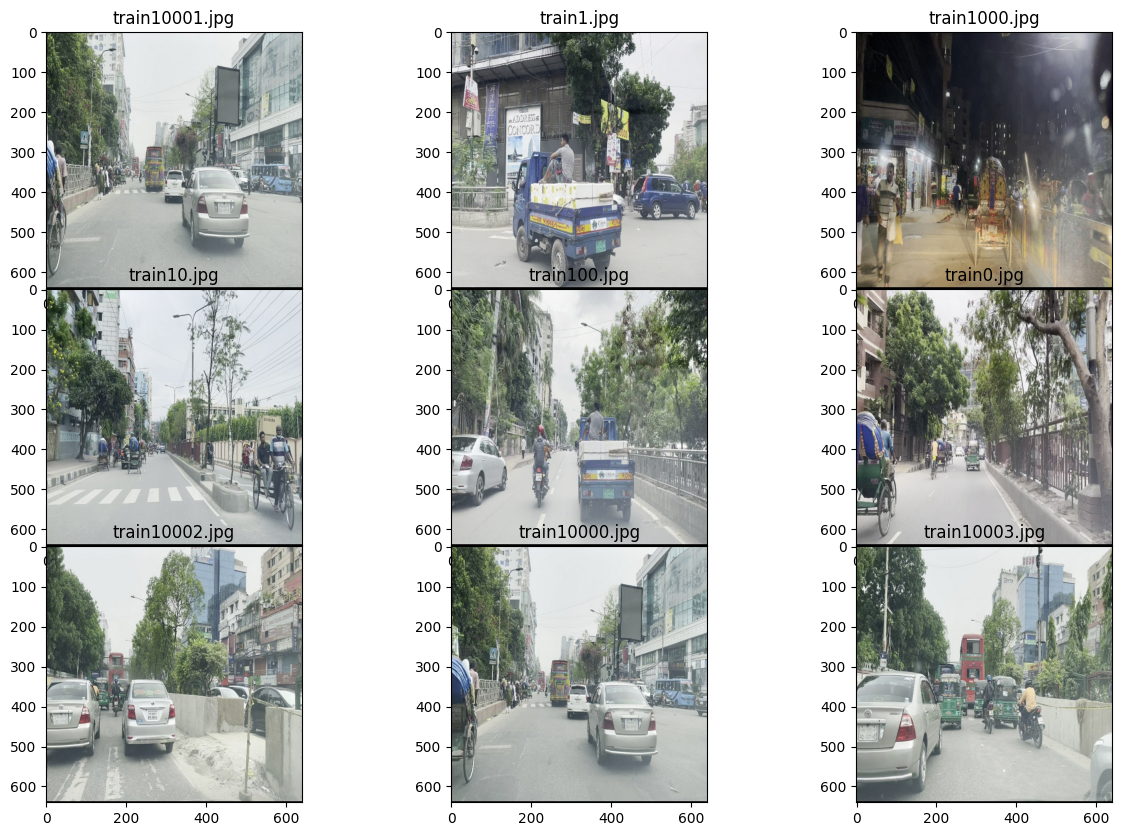

In [ ]:
image_list2 = list(folder_dict_sample.get("images_train").glob("*.jpg"))[:9]
random.shuffle(image_list2)
print("Selected image paths after shuffle:")
for img in image_list2:
    print(img)
show_ima_matrix(image_list2, show_axis=True)

##Modelo
Se carga la informacion asociada a la base de datos y se crea archivo YALM a versión del modelo YOLO que se va a utilizar. 'yolov8m.pt' indica que se está utilizando la variante YOLOv8m (la "m" representa un modelo de tamaño mediano).
Luego, se carga el modelo YOLO usando la librería correspondiente, y se instancia el modelo en la variable

In [ ]:
yaml_content = f"""

train: sample/train/images
val: sample/val/images
test: sample/test/images

train_labels: sample/train/labels
val_labels: sample/val/labels
test_labels: sample/test/labels

# Clases que el modelo debe detectar
names:
  0: person
  1: rickshaw
  2: rickshaw van
  3: auto rickshaw
  4: truck
  5: pickup truck
  6: private car
  7: motorcycle
  8: bicycle
  9: bus
  10: micro bus
  11: covered van
  12: human hauler
"""

with open('data/settings_no_tuned.yaml', 'w') as file:
    file.write(yaml_content)

! cat data/settings_no_tuned.yaml



train: sample/train/images
val: sample/val/images
test: sample/test/images

train_labels: sample/train/labels
val_labels: sample/val/labels
test_labels: sample/test/labels

# Clases que el modelo debe detectar
names:
  0: person
  1: rickshaw
  2: rickshaw van
  3: auto rickshaw
  4: truck
  5: pickup truck
  6: private car
  7: motorcycle
  8: bicycle
  9: bus
  10: micro bus
  11: covered van
  12: human hauler


Se plantea un modelo de 15 epoch y un batch de 4. A medida que avanzan las épocas, se observa una mejora gradual en las métricas, las perdidas disminuyen con el tiempo, lo que indica que el modelo está aprendiendo.

A lo largo del entrenamiento del modelo de detección de objetos, con el progreso de las épocas, se observa una mejora gradual en estas métricas. Las pérdidas asociadas a las predicciones de las cajas, la clasificación y los detalles de las posiciones (box_loss, cls_loss, dfl_loss) disminuyen, lo que indica que el modelo está aprendiendo. Al inicio, el valor de mAP50 era de 0.367 y, al finalizar las 15 épocas de entrenamiento, llegó a 0.541, mostrando una mejora significativa en la capacidad del modelo para detectar correctamente los objetos. La métrica mAP50-95 también mejoró, aunque de manera más gradual, subiendo de 0.248 a 0.403.

Después de 15 épocas, los resultados finales muestran que la precisión general del modelo es de 0.58 y el recall es de 0.492, lo que indica que el modelo logra una detección moderadamente precisa y completa de los objetos.
El mAP50 final es de 0.541, y el mAP50-95 es de 0.401, lo que refleja un buen rendimiento, especialmente considerando que se está evaluando en un rango de superposición más exigente. Estas métricas también mejoran a lo largo de las épocas. En la primera época, el valor de mAP50 era de 0.367 y al final del entrenamiento llega a 0.541, lo que indica que el modelo está aprendiendo a detectar mejor los objetos.
El mAP50-95 también mejora, aunque de manera más lenta (de 0.248 a 0.403).

In [ ]:
YOLO_VERSION = 'yolov8m.pt'
model = YOLO(f'{YOLO_VERSION}')

start_time = time.time()

model.train(
    data='data/settings_no_tuned.yaml',
    epochs=15,
    imgsz=640,
    batch=4,
    lr0=0.01,
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {elapsed_time:.2f} segundos")

metrics = model.val(data='data/settings_no_tuned.yaml')
print(metrics)

100% 49.7M/49.7M [00:01<00:00, 47.5MB/s]


New https://pypi.org/project/ultralytics/8.3.6 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.5 🚀 Python-3.9.16 torch-2.4.1+cu121 CPU (Intel Core(TM) i5-10210U 1.60GHz)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data/settings_no_tuned.yaml, epochs=15, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save

train: Scanning /app/data/sample/train/labels... 3736 images, 0 backgrounds, 0 corrupt: 100% 3736/3736 [00:01<00:00, 2188.24it/s]


train: New cache created: /app/data/sample/train/labels.cache


val: Scanning /app/data/sample/val/labels... 1004 images, 0 backgrounds, 0 corrupt: 100% 1004/1004 [00:00<00:00, 1946.95it/s]

val: New cache created: /app/data/sample/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 83 weight(decay=0.0), 90 weight(decay=0.0005), 89 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15         0G      1.017      1.917      1.147         15        640: 100% 934/934 [2:07:20<00:00,  8.18s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [10:14<00:00,  4.88s/it]


                   all       1004       7385      0.769      0.323      0.367      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15         0G     0.9492      1.218      1.129         34        640: 100% 934/934 [1:46:44<00:00,  6.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [09:43<00:00,  4.63s/it]

                   all       1004       7385      0.742      0.352      0.377      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15         0G     0.9252      1.084      1.117         38        640: 100% 934/934 [1:44:07<00:00,  6.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [09:43<00:00,  4.63s/it]

                   all       1004       7385      0.745      0.377      0.412      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15         0G     0.8842      0.946      1.092         48        640: 100% 934/934 [1:44:38<00:00,  6.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [09:47<00:00,  4.66s/it]

                   all       1004       7385      0.804      0.371      0.426      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15         0G     0.8291     0.8397      1.064         31        640: 100% 934/934 [1:44:30<00:00,  6.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [09:44<00:00,  4.64s/it]

                   all       1004       7385      0.728      0.393       0.45       0.32


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15         0G      0.749     0.6776      1.017         20        640: 100% 934/934 [1:44:11<00:00,  6.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [09:46<00:00,  4.66s/it]

                   all       1004       7385      0.471      0.441      0.453      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15         0G      0.712     0.6174     0.9936         18        640: 100% 934/934 [1:44:19<00:00,  6.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [09:45<00:00,  4.64s/it]

                   all       1004       7385      0.534      0.443      0.466      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15         0G     0.6829      0.579     0.9826         21        640: 100% 934/934 [1:44:12<00:00,  6.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [09:46<00:00,  4.65s/it]

                   all       1004       7385      0.553      0.457      0.487      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15         0G     0.6548      0.536     0.9661         22        640: 100% 934/934 [1:44:21<00:00,  6.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [09:41<00:00,  4.62s/it]

                   all       1004       7385      0.499      0.481      0.497      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15         0G     0.6337      0.508      0.961         19        640: 100% 934/934 [1:44:23<00:00,  6.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [09:32<00:00,  4.54s/it]

                   all       1004       7385      0.575      0.454      0.506      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15         0G     0.6068      0.481     0.9461         21        640: 100% 934/934 [2:18:03<00:00,  8.87s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [10:33<00:00,  5.03s/it]

                   all       1004       7385      0.547      0.479      0.513      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15         0G     0.5881     0.4552     0.9358         11        640: 100% 934/934 [1:56:59<00:00,  7.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [11:11<00:00,  5.33s/it]

                   all       1004       7385      0.571      0.484      0.527       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15         0G     0.5614     0.4283     0.9226         19        640: 100% 934/934 [2:23:09<00:00,  9.20s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [13:50<00:00,  6.59s/it]

                   all       1004       7385      0.585      0.516      0.538      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15         0G      0.542     0.4081     0.9153         33        640: 100% 934/934 [2:23:01<00:00,  9.19s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [10:26<00:00,  4.97s/it]

                   all       1004       7385      0.581      0.485      0.541      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15         0G     0.5249     0.3887      0.909         27        640: 100% 934/934 [2:02:06<00:00,  7.84s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [10:36<00:00,  5.05s/it]

                   all       1004       7385       0.58      0.492      0.537      0.401



15 epochs completed in 31.453 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 46.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 46.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.5 🚀 Python-3.9.16 torch-2.4.1+cu121 CPU (Intel Core(TM) i5-10210U 1.60GHz)
Model summary (fused): 236 layers, 23,210,359 parameters, 0 gradients, 67.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 126/126 [09:35<00:00,  4.57s/it]


                   all       1004       7385       0.58      0.486      0.541      0.403
                person        566       1917      0.851      0.686      0.815      0.553
              rickshaw        648       1587      0.878      0.738      0.855      0.671
          rickshaw van        160        240      0.732      0.325      0.459      0.213
         auto rickshaw        388        590      0.843      0.632      0.786      0.621
                 truck         62         65     0.0718     0.0154     0.0682     0.0485
          pickup truck         66         74      0.237      0.257      0.179      0.125
           private car        776       1420      0.867      0.706      0.845      0.664
            motorcycle        550        860      0.804      0.736      0.821      0.588
               bicycle        135        146      0.512      0.397      0.431      0.283
                   bus        169        182      0.692      0.717      0.743      0.595
             micro bu

val: Scanning /app/data/sample/val/labels.cache... 1004 images, 0 backgrounds, 0 corrupt: 100% 1004/1004 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 251/251 [09:52<00:00,  2.36s/it]


                   all       1004       7385       0.58      0.486      0.541      0.403
                person        566       1917      0.851      0.686      0.815      0.553
              rickshaw        648       1587      0.878      0.738      0.855      0.671
          rickshaw van        160        240      0.732      0.325      0.459      0.213
         auto rickshaw        388        590      0.843      0.632      0.786      0.621
                 truck         62         65     0.0718     0.0154     0.0682     0.0485
          pickup truck         66         74      0.237      0.257      0.179      0.125
           private car        776       1420      0.867      0.706      0.845      0.664
            motorcycle        550        860      0.804      0.736      0.821      0.588
               bicycle        135        146      0.512      0.397      0.431      0.283
                   bus        169        182      0.692      0.717      0.743      0.595
             micro bu

El modelo muestra un excelente desempeño en la detección de la clase "persona", con 1344 predicciones correctas y muy pocos errores de confusión con otras clases, lo que indica una alta precisión en la identificación de personas. De manera similar, la clase "rickshaw" también presenta buenos resultados, con 1185 predicciones correctas, aunque con algunas confusiones menores con "rickshaw van" y "auto rickshaw", lo cual es comprensible debido a las características visuales compartidas entre estos vehículos.

Se observan errores significativos entre clases con características físicas parecidas. Por ejemplo, "Rickshaw van" se confunde con "rickshaw" en 80 ocasiones, lo que es lógico dada la similitud visual entre estos vehículos.
"Auto rickshaw" se confunde con "rickshaw" en 32 casos, probablemente debido a la estructura y apariencia similar. Además, el modelo presenta confusiones entre el fondo ("background") y clases como "person", "rickshaw", y "private car", lo que podría deberse a la dificultad de separar correctamente el fondo de objetos pequeños o parcialmente visibles.
El modelo también se desempeña bien en la identificación de otras clases, como "private car" con 981 predicciones correctas y "motorcycle" con 638, lo que demuestra una sólida capacidad de detección en estas categorías.

Por otro lado, clases como "truck" y "pickup truck" tienen menos predicciones correctas (13 y 49 instancias, respectivamente). Esto puede deberse a que estas clases están subrepresentadas en los datos de entrenamiento o presentan características visuales más difíciles de distinguir. Clases minoritarias como "covered van" y "human hauler" también tienen muy pocas predicciones correctas, lo que sugiere dificultades del modelo para generalizar en estas categorías.

En resumen, el modelo generaliza bien en clases mayoritarias como "person", "rickshaw" y "private car", que cuentan con suficientes ejemplos para que el modelo aprenda sus características distintivas. Sin embargo, enfrenta dificultades para generalizar en clases menos representadas o más complejas, como "rickshaw van", "truck", y "covered van", donde ocurren confusiones frecuentes. Esto sugiere la necesidad de más datos o ajustes en el modelo para mejorar el rendimiento en estas clases.

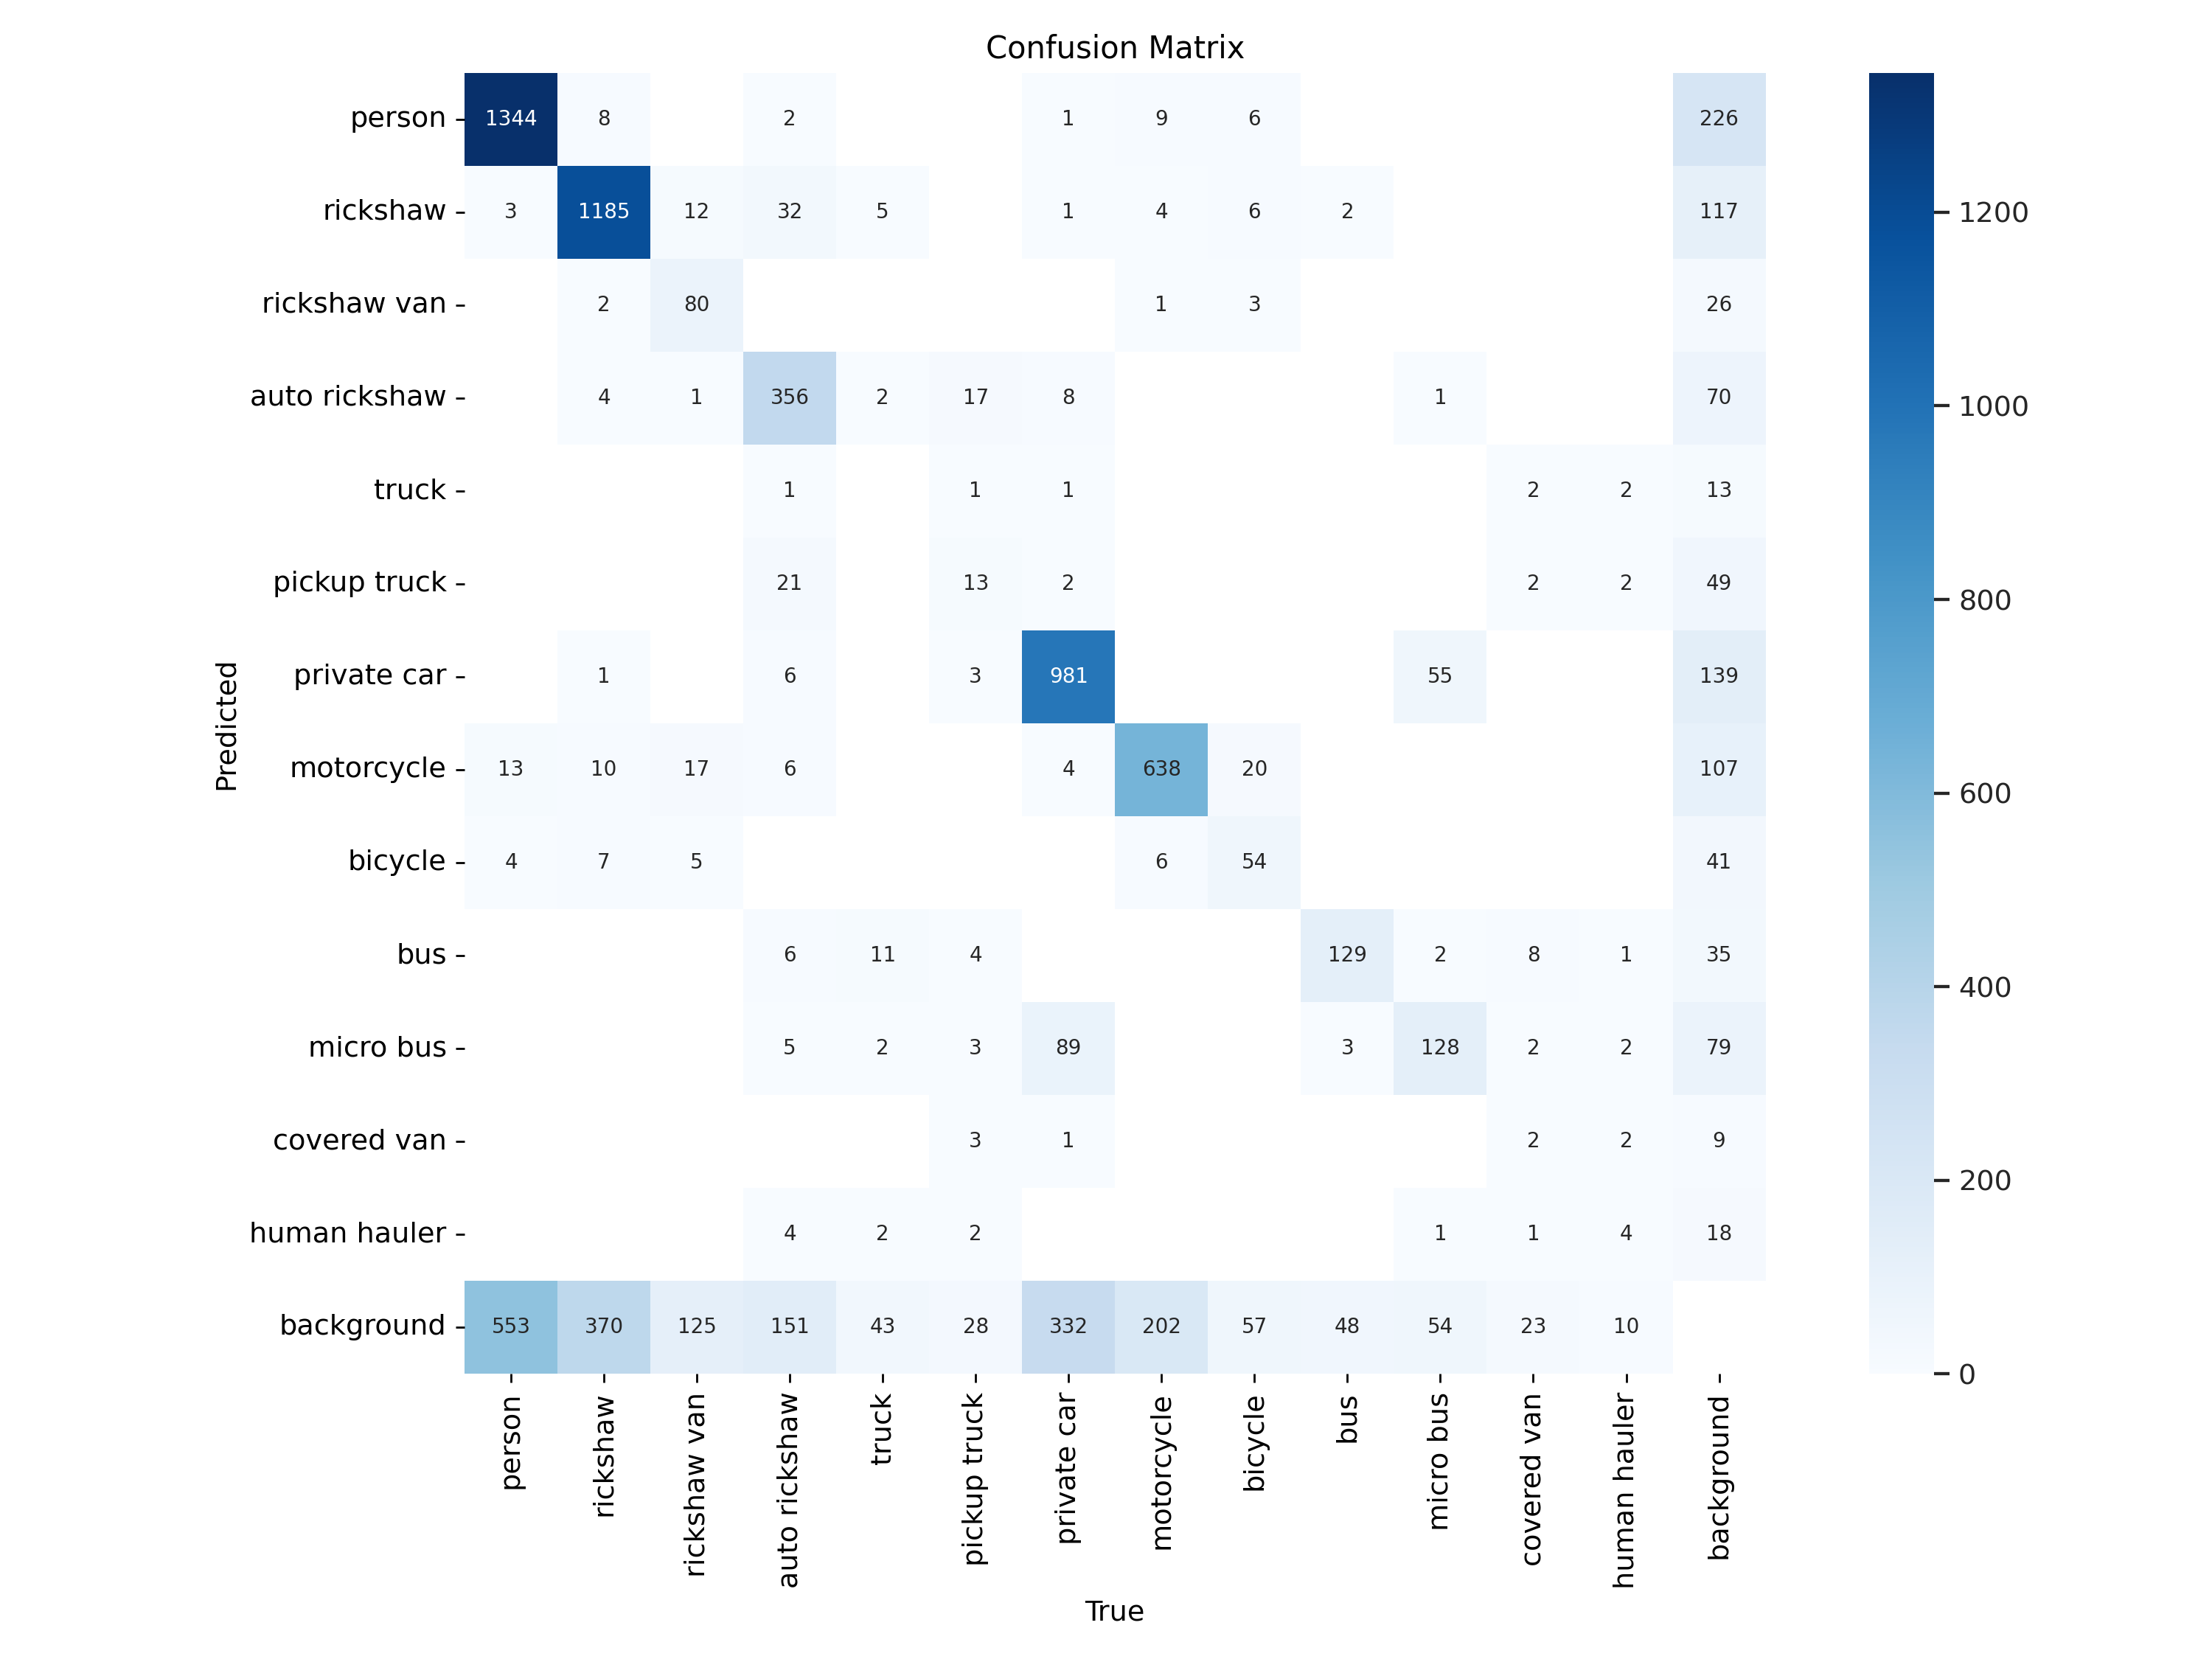

In [ ]:
Image.open('runs/detect/train/confusion_matrix.png')

 En general, el modelo tiene un buen rendimiento en las clases mayoritarias, como "person", "rickshaw", "private car", y "motorcycle", que tienen suficientes instancias en el conjunto de datos y características distintivas que el modelo puede aprender. Sin embargo, en clases menos representadas o más difíciles de distinguir, como "truck", "covered van", y "human hauler", el rendimiento es notablemente bajo, lo que podría mejorarse con más datos de entrenamiento o ajustes en el modelo.

 El sistema ajusta automáticamente el tamaño de la imagen a 672 (que sí es divisible entre 32) para asegurar que la arquitectura de la red funcione correctamente.

DE acuerdo con las metricas de salida se observa el comportamiento de cada clase. Para la clase (person), el rendimiento es excelente, con una precisión de 0.817 y un recall de 0.715, sugiere que el modelo es muy bueno para detectar personas con pocas predicciones incorrectas (falsos positivos y falsos negativos). El mAP50 es muy alto (0.813), lo que indica que las predicciones son precisas en la mayoría de los casos.

La clase Rickshaw también presenta un excelente rendimiento, con una precisión de 0.866, un recall de 0.745 y un mAP50 de 0.849. Ahora bien, aunque el rendimiento es bueno, hay cierta confusión entre estas dos clases, lo que se refleja en un recall más bajo para rickshaw van (0.384) y para auto rickshaw (0.669). El mAP50 para rickshaw van es de 0.485, lo que sugiere que el modelo tiene dificultades para distinguir claramente entre estas clases similares.
Para el caso de la clase Truck el rendimiento es muy bajo, con una precisión de solo 0.111 y un recall de 0.0615, lo que indica que el modelo no está detectando correctamente los camiones. Esto a causa de la falta de datos suficientes de esta clas. Esta situación se refleja en las clases minoritarias (bicycle, bus, micro bus, covered van, human hauler) pues tienen un rendimiento moderado o bajo. Por ejemplo, bicycle tiene una precisión de 0.483 y un mAP50 de 0.434, lo que indica un rendimiento aceptable. Sin embargo, clases como covered van y human hauler muestran un rendimiento muy bajo, con precisiones de 0.251 y 0.158 respectivamente, el modelo tiene dificultades para detectarlas debido a su baja representación en los datos de entrenamiento o a características visuales más difíciles de distinguir.

In [ ]:
results = model.val(data="data/settings_no_tuned.yaml", imgsz=660, name="val")

WARNING ⚠️ imgsz=[660] must be multiple of max stride 32, updating to [672]
Ultralytics 8.3.5 🚀 Python-3.9.16 torch-2.4.1+cu121 CPU (Intel Core(TM) i5-10210U 1.60GHz)


val: Scanning /app/data/sample/val/labels.cache... 1004 images, 0 backgrounds, 0 corrupt: 100% 1004/1004 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 251/251 [11:17<00:00,  2.70s/it]


                   all       1004       7385      0.556      0.518      0.537      0.406
                person        566       1917      0.817      0.715      0.813      0.558
              rickshaw        648       1587      0.866      0.745      0.849      0.679
          rickshaw van        160        240      0.698      0.384      0.485      0.239
         auto rickshaw        388        590      0.837      0.669      0.783      0.632
                 truck         62         65      0.111     0.0615     0.0645     0.0406
          pickup truck         66         74      0.214      0.297      0.154      0.111
           private car        776       1420      0.858      0.711      0.837      0.677
            motorcycle        550        860       0.81      0.722      0.813      0.583
               bicycle        135        146      0.483      0.428      0.434      0.297
                   bus        169        182      0.637      0.713      0.741       0.61
             micro bu

Algunos ejemplos de validación. Se detalla la detección de clases con alta representación en el la base de datos.

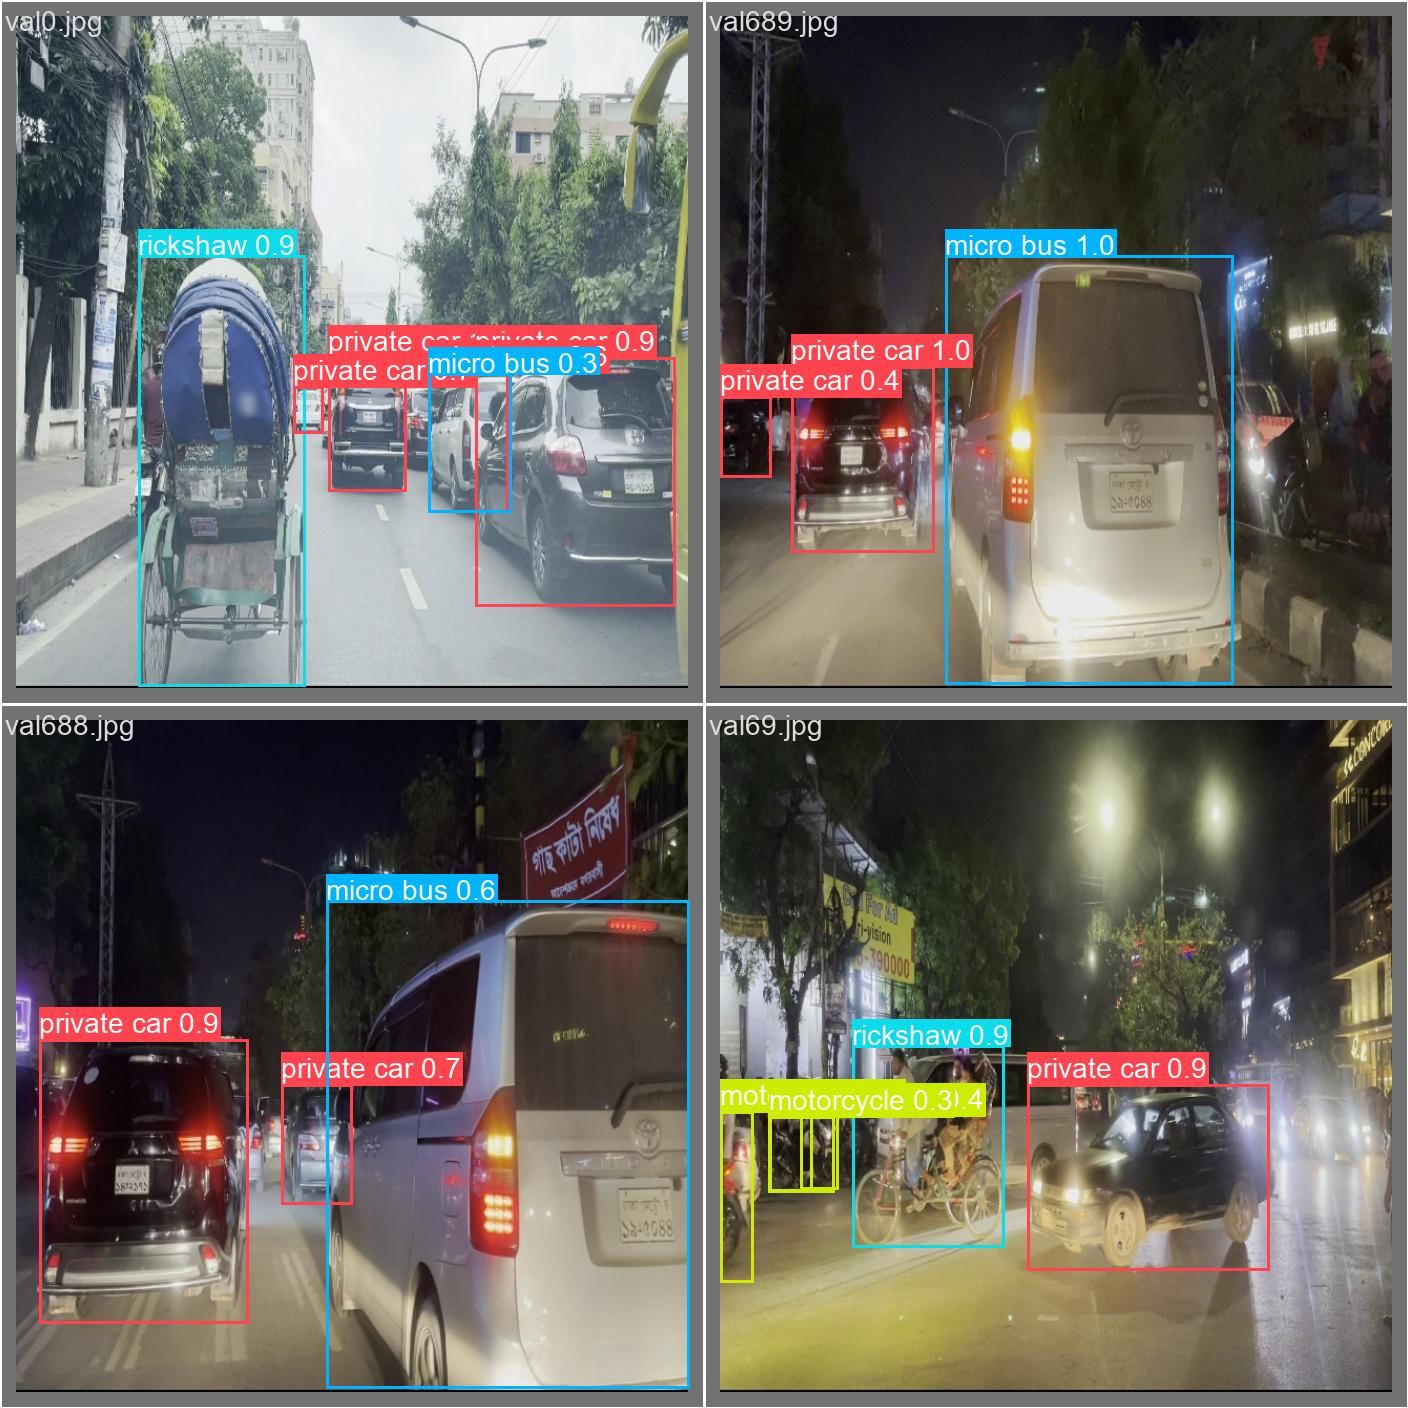

In [ ]:
Image.open('runs/detect/val/val_batch0_pred.jpg')

En concordancia con lo evidenciado previamente, el modelo tiene un buen rendimiento en ambas clases ("private car" y "motorcycle"). Esto sugiere que ha aprendido a distinguir estas clases de manera efectiva en las imágenes, con pocas confusiones con otras clases.
Al ser, el recall un poco más bajo indica que el modelo podría mejorar en la detección de todas las instancias de estas clases en las imágenes, posiblemente ajustando parámetros o mejorando el dataset.
El mAP50 alto indica que no solo clasifica bien, sino que también localiza correctamente los objetos, lo cual es un indicador importante de un buen rendimiento en detección de objetos.
Este análisis

In [ ]:
results = model.predict(source="data/sample/test/images", conf=0.25, save=True, imgsz=640, name="predict")


image 1/649 /app/data/sample/test/images/test0.jpg: 640x640 1 rickshaw, 1 rickshaw van, 1 motorcycle, 1 bus, 650.2ms
image 2/649 /app/data/sample/test/images/test1.jpg: 640x640 1 person, 1 rickshaw, 2 motorcycles, 1 bus, 409.1ms
image 3/649 /app/data/sample/test/images/test10.jpg: 640x640 1 rickshaw van, 2 motorcycles, 367.6ms
image 4/649 /app/data/sample/test/images/test100.jpg: 640x640 2 private cars, 1 micro bus, 363.1ms
image 5/649 /app/data/sample/test/images/test101.jpg: 640x640 2 private cars, 1 motorcycle, 380.5ms
image 6/649 /app/data/sample/test/images/test102.jpg: 640x640 1 auto rickshaw, 1 pickup truck, 2 private cars, 1 micro bus, 519.4ms
image 7/649 /app/data/sample/test/images/test103.jpg: 640x640 2 private cars, 1 micro bus, 374.0ms
image 8/649 /app/data/sample/test/images/test104.jpg: 640x640 1 private car, 2 micro buss, 362.9ms
image 9/649 /app/data/sample/test/images/test105.jpg: 640x640 1 private car, 1 bus, 1 micro bus, 448.1ms
image 10/649 /app/data/sample/test/i

In [ ]:
predict_path = 'runs/detect/predict'

img_list = [filename for filename in os.listdir(predict_path)]
img_count = len(img_list)
print(f"El número total de imágenes es: {img_count}")

El número total de imágenes es: 649


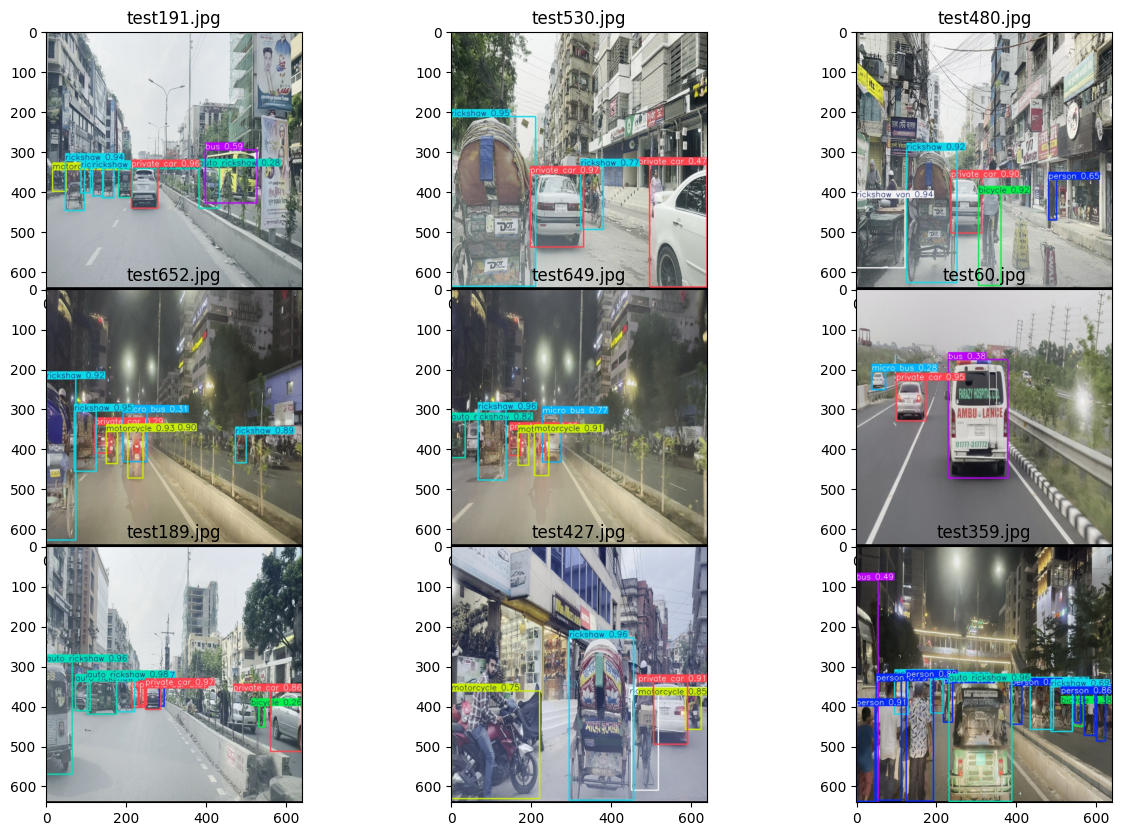

In [ ]:
img_fc_list = [os.path.join(predict_path, filename) for filename in img_list]
random.shuffle(img_fc_list)
show_ima_matrix(img_fc_list[0:9], show_axis=True)